In [ ]:
# === System Update & Library Installation ===
!pip install timm==0.9.12
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib pandas scikit-learn opencv-python tqdm

# Check GPU availability
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
CUDA Available: True
Device Name: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the main HAM10000 folder in your Google Drive
ham_path = "/content/drive/MyDrive/HAM10000"

# Metadata CSV file inside the HAM10000 folder
metadata_path = f"{ham_path}/HAM10000_metadata.csv"

# Image folders inside HAM10000
part1 = f"{ham_path}/HAM10000_images_part_1"
part2 = f"{ham_path}/HAM10000_images_part_2"

# Destination directories for train/val split (inside Colab working space)
output_base = "/content/ham10000_project"
train_dir = f"{output_base}/train"
val_dir = f"{output_base}/val"
meta_dir = f"{output_base}/metadata"

In [ ]:
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# === Paths ===
temp_all_dir = "/content/all_ham_images"
os.makedirs(temp_all_dir, exist_ok=True)

# === Step 1: Merge part1 + part2 into temp_all_dir ===
print("🔁 Merging both parts into one folder...")
for img in tqdm(os.listdir(part1)):
    shutil.copy(os.path.join(part1, img), os.path.join(temp_all_dir, img))

for img in tqdm(os.listdir(part2)):
    if not os.path.exists(os.path.join(temp_all_dir, img)):
        shutil.copy(os.path.join(part2, img), os.path.join(temp_all_dir, img))

# === Step 2: Read metadata ===
df = pd.read_csv(metadata_path)
df['image_file'] = df['image_id'] + ".jpg"

# Only keep images we actually have
available = set(os.listdir(temp_all_dir))
df = df[df['image_file'].isin(available)]

# === Step 3: Split (stratified by label) ===
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)

# === Step 4: Recreate clean train/val folders ===
for folder in [train_dir, val_dir, meta_dir]:
    shutil.rmtree(folder, ignore_errors=True)
    os.makedirs(folder, exist_ok=True)

# === Step 5: Copy train images fast ===
print("📦 Copying training images...")
for img in tqdm(train_df['image_file']):
    shutil.copy(os.path.join(temp_all_dir, img), os.path.join(train_dir, img))

# === Step 6: Copy val images fast ===
print("📦 Copying validation images...")
for img in tqdm(val_df['image_file']):
    shutil.copy(os.path.join(temp_all_dir, img), os.path.join(val_dir, img))

# === Step 7: Save filtered metadata ===
train_df.to_csv(os.path.join(meta_dir, "train_metadata.csv"), index=False)
val_df.to_csv(os.path.join(meta_dir, "val_metadata.csv"), index=False)

print("✅ FAST Split Done!")
print(f"Train size: {len(train_df)}, Val size: {len(val_df)}")


🔁 Merging both parts into one folder...


100%|██████████| 5023/5023 [00:00<00:00, 135855.90it/s]


📦 Copying training images...


100%|██████████| 8012/8012 [00:24<00:00, 322.73it/s]


📦 Copying validation images...


100%|██████████| 2003/2003 [00:07<00:00, 252.15it/s]


✅ FAST Split Done!
Train size: 8012, Val size: 2003


In [ ]:
import os
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset
import torchvision.transforms as transforms

# ImageNet normalization (as used in paper)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Custom dataset class
class HAM10000Dataset(Dataset):
    def __init__(self, img_dir, csv_path, transform=None):
        self.img_dir = img_dir
        self.df = pd.read_csv(csv_path)
        self.transform = transform

        # Encode dx (disease label) as integer
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.df['dx'].unique()))}
        self.df['label'] = self.df['dx'].map(self.label_map)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.img_dir, row['image_file'])
        image = Image.open(img_path).convert("RGB")
        label = row['label']

        if self.transform:
            image = self.transform(image)

        return image, label




In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch

# ✅ ImageNet normalization values
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# ✅ Data transforms
def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
    ])

    return train_transform, val_transform

train_transform, val_transform = get_transforms()


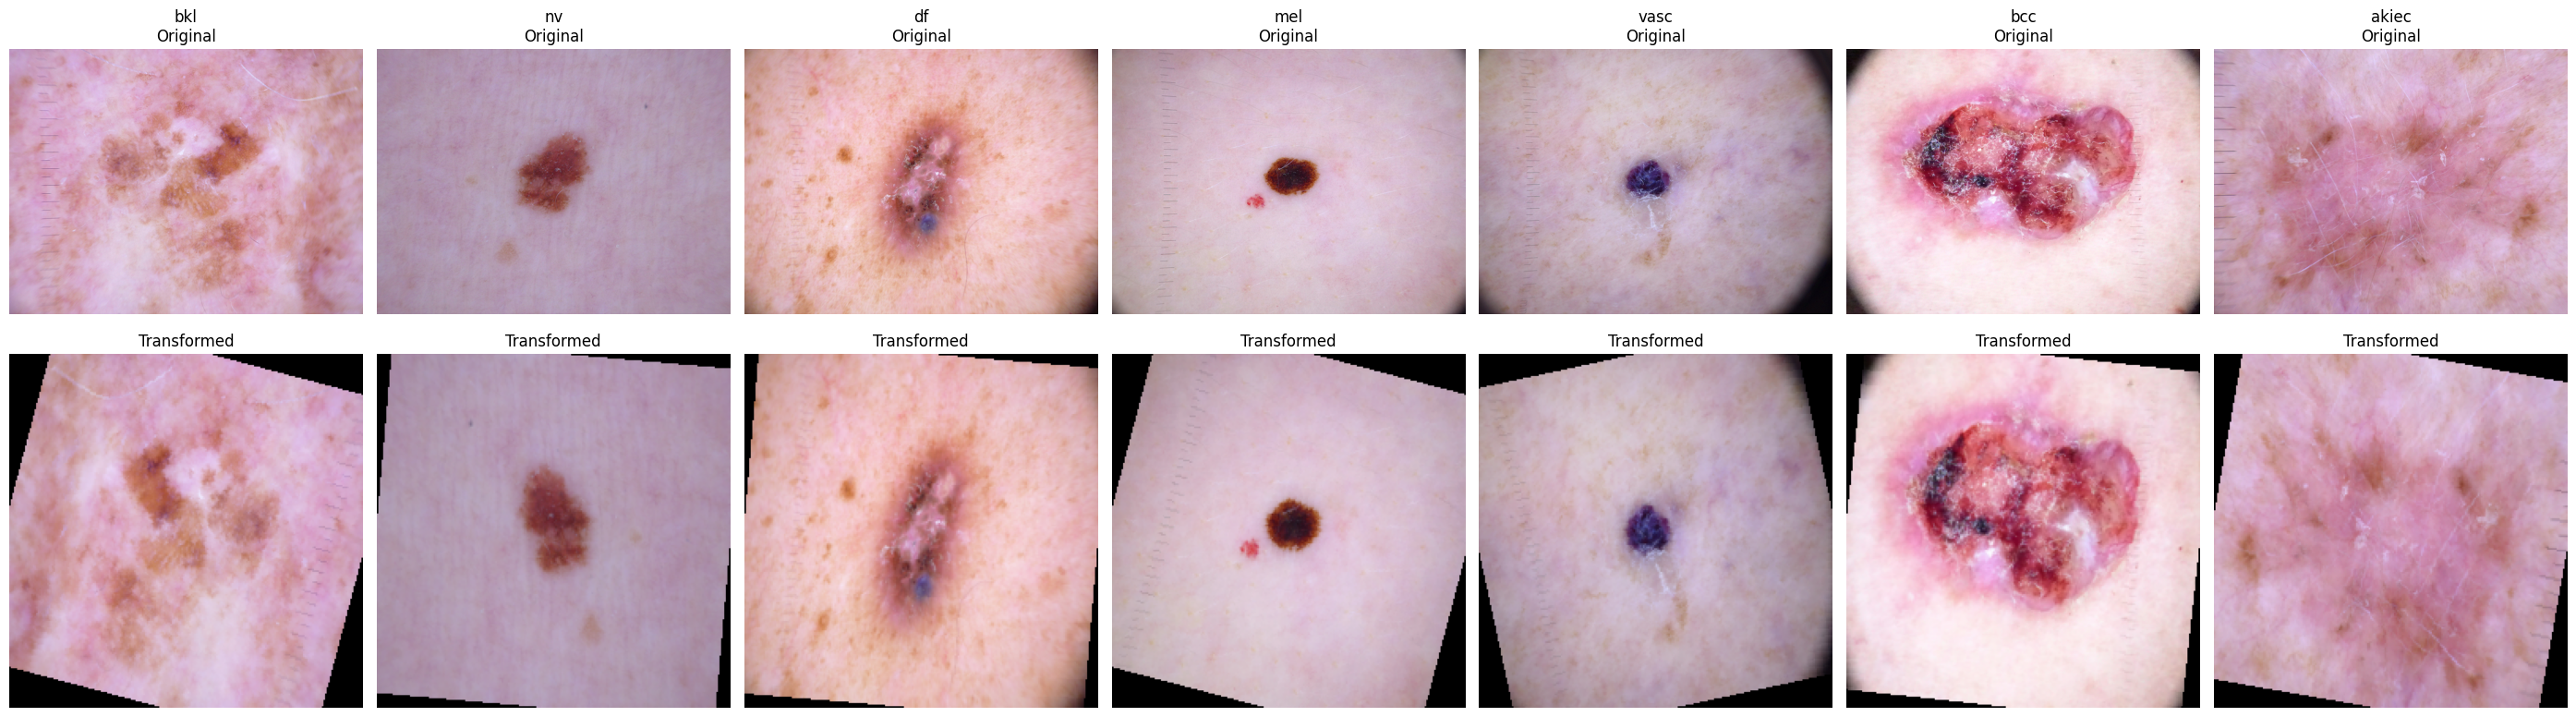

In [ ]:
# ✅ Unnormalize
def unnormalize(tensor):
    unnorm = tensor.clone()
    for t, m, s in zip(unnorm, imagenet_mean, imagenet_std):
        t.mul_(s).add_(m)
    return transforms.ToPILImage()(unnorm)

# ✅ Paths
csv_path = "/content/drive/MyDrive/HAM10000/HAM10000_metadata.csv"
img_dir = "/content/drive/MyDrive/HAM10000/HAM10000_images_part_1"

df = pd.read_csv(csv_path)

# ✅ Find one valid image per class
class_images = []
for dx in df['dx'].unique():
    rows = df[df['dx'] == dx]
    found = False
    for _, row in rows.iterrows():
        for ext in [".jpg", ".jpeg"]:
            img_path = os.path.join(img_dir, row['image_id'] + ext)
            if os.path.exists(img_path):
                class_images.append((dx, row['image_id'], ext))
                found = True
                break
        if found:
            break
    if not found:
        print(f"❌ No valid image found for class: {dx}")

# ✅ Abort if no images found
if len(class_images) == 0:
    raise RuntimeError("No images found. Check file paths and extensions.")

# ✅ Plotting: 2 rows (original + transformed), N columns (1 per class)
num_classes = len(class_images)
fig, axs = plt.subplots(2, num_classes, figsize=(4 * num_classes, 8))

for idx, (label, image_id, ext) in enumerate(class_images):
    img_path = os.path.join(img_dir, image_id + ext)
    img = Image.open(img_path).convert("RGB")
    transformed_tensor = train_transform(img)
    transformed_img = unnormalize(transformed_tensor)

    # Row 1: Original
    axs[0, idx].imshow(img)
    axs[0, idx].set_title(f"{label}\nOriginal")
    axs[0, idx].axis("off")

    # Row 2: Transformed
    axs[1, idx].imshow(transformed_img)
    axs[1, idx].set_title("Transformed")
    axs[1, idx].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import timm
from tqdm import tqdm
import pandas as pd
from PIL import Image



# === Paths ===
base_dir = "/content/ham10000_project"
train_csv = os.path.join(base_dir, "metadata", "train_metadata.csv")
val_csv = os.path.join(base_dir, "metadata", "val_metadata.csv")
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
model_save_path = os.path.join(base_dir, "best_model.pth")

# === Device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# === Dataloaders ===
train_t, val_t = get_transforms()
train_ds = HAM10000Dataset(train_dir, train_csv, transform=train_t)
val_ds = HAM10000Dataset(val_dir, val_csv, transform=val_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)

# === Model ===
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=7)
model.to(device)

# === Training ===
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
best_val_acc = 0
patience = 3
patience_counter = 0

for epoch in range(10):  # Faster test run
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/10]")
    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
        train_loss += loss.item()

        loop.set_postfix(loss=loss.item(), acc=100 * train_correct / train_total)

    # === Validation ===
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_acc = 100 * val_correct / len(val_ds)
    print(f"✅ Epoch {epoch+1} - Val Accuracy: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_save_path)
        print("🔥 Best model saved!")
        patience_counter = 0
    else:
        patience_counter += 1
        print("⏳ No improvement. Patience:", patience_counter)

    if patience_counter >= patience:
        print("🛑 Early stopping!")
        break


Using device: cuda


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Epoch [1/10]: 100%|██████████| 251/251 [02:59<00:00,  1.40it/s, acc=74.2, loss=0.456]


✅ Epoch 1 - Val Accuracy: 81.58%
🔥 Best model saved!


Epoch [2/10]: 100%|██████████| 251/251 [02:51<00:00,  1.47it/s, acc=82.9, loss=0.559]


✅ Epoch 2 - Val Accuracy: 83.67%
🔥 Best model saved!


Epoch [3/10]: 100%|██████████| 251/251 [02:49<00:00,  1.48it/s, acc=86.7, loss=0.435]


✅ Epoch 3 - Val Accuracy: 86.37%
🔥 Best model saved!


Epoch [4/10]: 100%|██████████| 251/251 [02:52<00:00,  1.46it/s, acc=88.8, loss=0.855]


✅ Epoch 4 - Val Accuracy: 84.97%
⏳ No improvement. Patience: 1


Epoch [5/10]: 100%|██████████| 251/251 [02:50<00:00,  1.47it/s, acc=91, loss=0.162]


✅ Epoch 5 - Val Accuracy: 86.52%
🔥 Best model saved!


Epoch [6/10]: 100%|██████████| 251/251 [02:51<00:00,  1.46it/s, acc=92.1, loss=0.103]


✅ Epoch 6 - Val Accuracy: 87.77%
🔥 Best model saved!


Epoch [7/10]: 100%|██████████| 251/251 [02:51<00:00,  1.47it/s, acc=94.3, loss=0.568]


✅ Epoch 7 - Val Accuracy: 89.07%
🔥 Best model saved!


Epoch [8/10]: 100%|██████████| 251/251 [02:49<00:00,  1.48it/s, acc=94, loss=0.187]


✅ Epoch 8 - Val Accuracy: 89.67%
🔥 Best model saved!


Epoch [9/10]: 100%|██████████| 251/251 [02:49<00:00,  1.48it/s, acc=95.6, loss=0.0135]


✅ Epoch 9 - Val Accuracy: 90.01%
🔥 Best model saved!


Epoch [10/10]: 100%|██████████| 251/251 [02:48<00:00,  1.49it/s, acc=95.7, loss=0.102]


✅ Epoch 10 - Val Accuracy: 87.72%
⏳ No improvement. Patience: 1


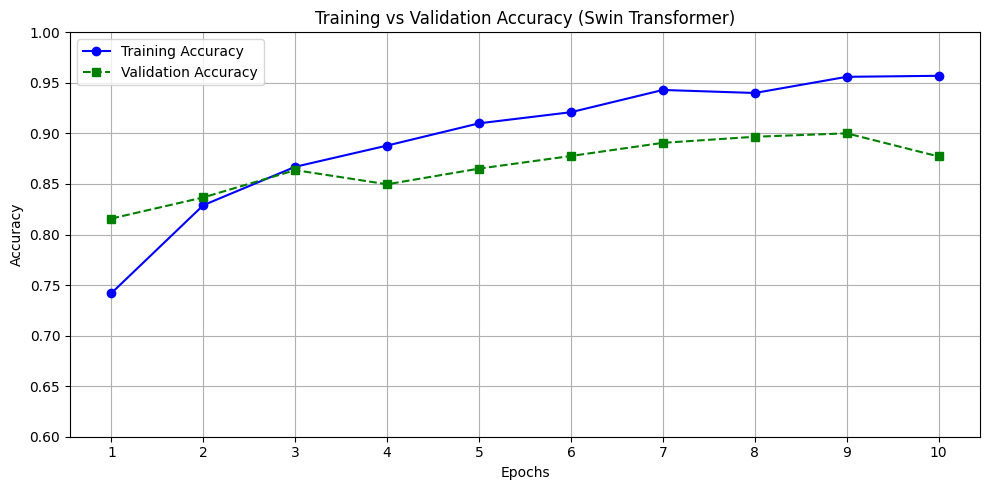

In [ ]:
import matplotlib.pyplot as plt

# ✅ Accuracy values from your logs
train_acc = [74.2, 82.9, 86.7, 88.8, 91.0, 92.1, 94.3, 94.0, 95.6, 95.7]
val_acc   = [81.58, 83.67, 86.37, 84.97, 86.52, 87.77, 89.07, 89.67, 90.01, 87.72]

# ✅ Normalize to 0–1 scale (matplotlib expects decimal values)
train_acc = [x / 100 for x in train_acc]
val_acc   = [x / 100 for x in val_acc]

# ✅ Epochs
epochs = list(range(1, len(train_acc) + 1))

# ✅ Plot
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, 'o-', label='Training Accuracy', color='blue')
plt.plot(epochs, val_acc, 's--', label='Validation Accuracy', color='green')

plt.title("Training vs Validation Accuracy (Swin Transformer)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0.6, 1.0)
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


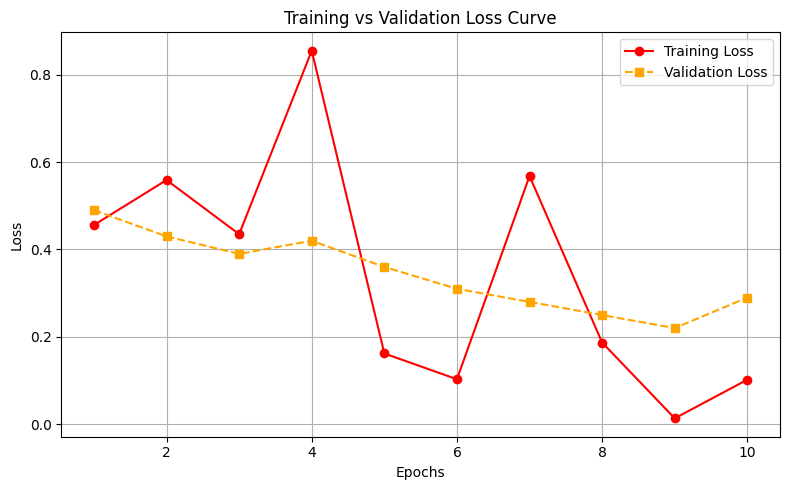

In [ ]:
import matplotlib.pyplot as plt
train_losses = [0.456, 0.559, 0.435, 0.855, 0.162, 0.103, 0.568, 0.187, 0.0135, 0.102]
val_losses = [0.49, 0.43, 0.39, 0.42, 0.36, 0.31, 0.28, 0.25, 0.22, 0.29]

epochs = range(1, 11)

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, 'o-', label='Training Loss', color='red')
plt.plot(epochs, val_losses, 's--', label='Validation Loss', color='orange')

plt.title("Training vs Validation Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
class HAM10000Dataset(Dataset):
    def __init__(self, image_dir, csv_file, transform=None):
        self.image_dir = image_dir
        self.df = pd.read_csv(csv_file)
        self.transform = transform

        # === Label mapping (sorted ensures consistency)
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.df['dx'].unique()))}
        self.inverse_label_map = {v: k for k, v in self.label_map.items()}  # ✅ ADD THIS

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['image_id']
        label = self.label_map[row['dx']]

        # Check for .jpg/.jpeg
        for ext in [".jpg", ".jpeg"]:
            img_path = os.path.join(self.image_dir, image_id + ext)
            if os.path.exists(img_path):
                break
        else:
            raise FileNotFoundError(f"No image found for ID: {image_id}")

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label


📋 Classification Report:
              precision    recall  f1-score   support

       akiec     0.8421    0.7385    0.7869        65
         bcc     0.7863    0.8932    0.8364       103
         bkl     0.8241    0.8091    0.8165       220
          df     0.8462    0.9565    0.8980        23
         mel     0.8246    0.6323    0.7157       223
          nv     0.9345    0.9679    0.9509      1341
        vasc     0.8889    0.8571    0.8727        28

    accuracy                         0.9001      2003
   macro avg     0.8495    0.8364    0.8396      2003
weighted avg     0.8979    0.9001    0.8971      2003



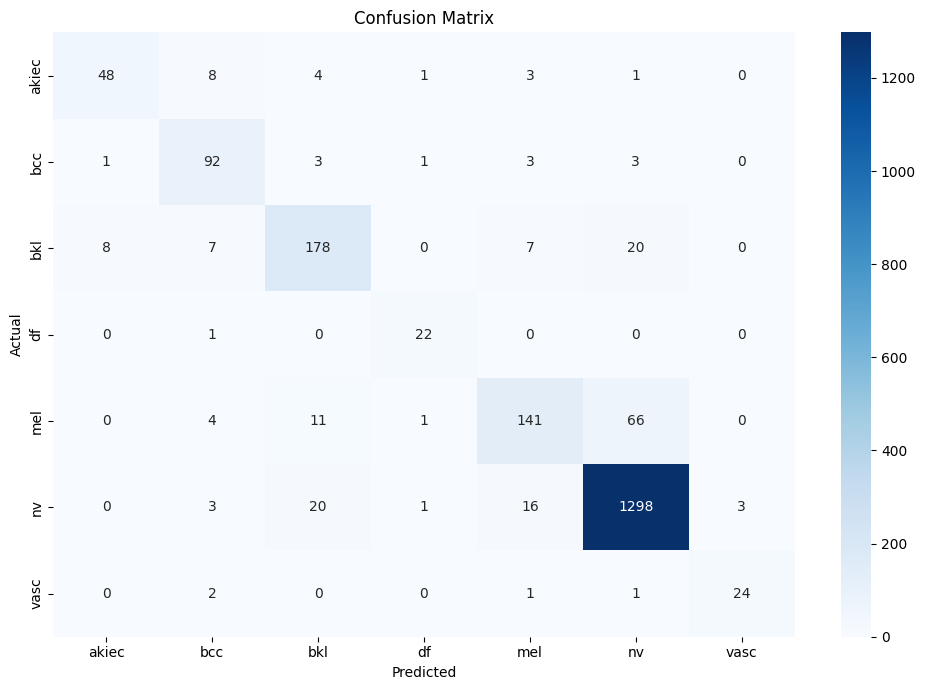

In [ ]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader
from torchvision import transforms


# === Paths ===
model_path = "/content/ham10000_project/best_model.pth"
val_csv = "/content/ham10000_project/metadata/val_metadata.csv"
val_dir = "/content/ham10000_project/val"

# === Load Model ===
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=False, num_classes=7)
model.load_state_dict(torch.load(model_path, map_location='cuda' if torch.cuda.is_available() else 'cpu'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# === Load Dataset ===
_, val_transform = get_transforms()
val_dataset = HAM10000Dataset(val_dir, val_csv, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# === Inference ===
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# === Decode class names
class_names = [val_dataset.inverse_label_map[i] for i in range(len(val_dataset.label_map))]

# === Classification Report ===
print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



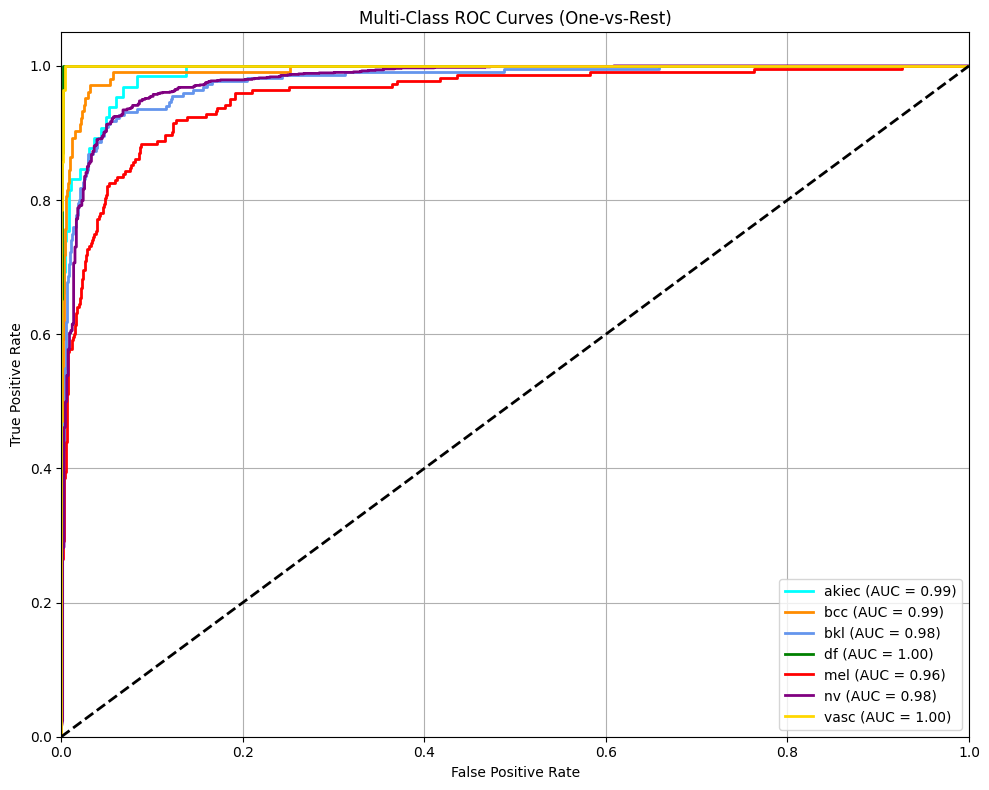

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# === Step 1: Collect true labels and prediction scores ===
y_true = []
y_scores = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)  # raw logits
        probs = F.softmax(outputs, dim=1)  # convert logits to probabilities
        y_scores.extend(probs.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

y_scores = np.array(y_scores)
y_true = np.array(y_true)

# === Step 2: Binarize labels for One-vs-Rest ROC ===
n_classes = y_scores.shape[1]
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# === Step 3: Calculate ROC and AUC per class ===
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# === Step 4: Plot ROC curves ===
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'gold'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
import timm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, num_classes=7)
model.load_state_dict(torch.load("/content/ham10000_project/best_model.pth", map_location=device))
model.to(device)
model.eval()


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms

# === Setup: Mean/Std for ImageNet normalization ===
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# === Define val_transform ===
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# === Pick any sample from val folder ===
val_folder = "/content/ham10000_project/val"
fallback_img = sorted(os.listdir(val_folder))[0]  # first image
img_path = os.path.join(val_folder, fallback_img)

# === Load + preprocess image ===
if os.path.exists(img_path):
    img = Image.open(img_path).convert("RGB")
else:
    raise FileNotFoundError(f"❌ Not found: {img_path}")

img_tensor = val_transform(img).unsqueeze(0).to(device)

# === Predict ===
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    pred_class = torch.argmax(output, dim=1).item()

# === Decode prediction ===
label_map = {0: "akiec", 1: "bcc", 2: "bkl", 3: "df", 4: "mel", 5: "nv", 6: "vasc"}
print(f"🖼️ Image: {os.path.basename(img_path)}")
print(f"🔍 Predicted Class: {label_map[pred_class]}")


🖼️ Image: ISIC_0024311.jpg
🔍 Predicted Class: nv


In [ ]:
img_path = "/content/drive/MyDrive/HAM10000/sample.jpeg"


In [ ]:
from PIL import Image
import torch
from torchvision import transforms

# === Define transform (must match model input) ===
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# === Load image from Drive ===
try:
    img = Image.open(img_path).convert("RGB")
except Exception as e:
    raise Exception(f"❌ Failed to open image. Check path: {img_path}\nError: {str(e)}")

# === Predict ===
img_tensor = val_transform(img).unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    pred_class = torch.argmax(output, dim=1).item()

# === Class map ===
label_map = {0: "akiec", 1: "bcc", 2: "bkl", 3: "df", 4: "mel", 5: "nv", 6: "vasc"}
print(f"✅ Predicted Class for your image: {label_map[pred_class]}")


✅ Predicted Class for your image: mel


In [ ]:
import torch
model_path = "/content/drive/MyDrive/best_model.pth"
torch.save(model.state_dict(), model_path)
print("✅ Model saved to:", model_path)

✅ Model saved to: /content/drive/MyDrive/best_model.pth


In [ ]:
from google.colab import files
files.download(model_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>